### Preparation

In [6]:
import argparse
import random

import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric_temporal.signal import temporal_signal_split

from src.data.dataloaders import kelmarsh
from src.models.architectures import mlp, temporal_gnn

In [7]:
fix_seed = 42
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

In [8]:
model_dict = {
    "MLP": mlp,
    "TemporalGNN": temporal_gnn,
}

data_dict = {
    "kelmarsh": kelmarsh,
}

### Configuration

In [9]:
# configure training session
class Args(argparse.Namespace):
  model = None
  data = 'kelmarsh'
  num_timesteps_in = 12
  num_timesteps_out = 12
  num_static_node_features = None  # will be extracted from data

args=Args()

### Data Preparation

In [10]:
dataloader = data_dict[args.data].DataLoader()
data = dataloader.get_dataset(
    num_timesteps_in=args.num_timesteps_in, num_timesteps_out=args.num_timesteps_out
)
args.num_static_node_features = data[0].x.shape[1]
train_data, test_data = temporal_signal_split(data, train_ratio=0.8)

In [11]:
print(f'We have {len(data.features)} graphs, one for each time window of length {args.num_timesteps_in}.')
print(f'Each graph has {data[0].x.shape[0]} nodes and {data[0].x.shape[1]}x{data[0].x.shape[2]} feature(s) per node,')
print(f'i.e., {data[0].x.shape[1]} features per time point,')
print(f'and {data.edge_index.shape[1]} edges with 1 feature per edge (the edge weight).')
print(f'Each node has {data[0].y.shape[1]} labels (i.e., the future values to predict).')
print(f'Our train and test data consists of {len(train_data.features)} and {len(test_data.features)} graphs, respectively.')

We have 52537 graphs, one for each time window of length 12.
Each graph has 6 nodes and 2x12 feature(s) per node,
i.e., 2 features per time point,
and 30 edges with 1 feature per edge (the edge weight).
Each node has 12 labels (i.e., the future values to predict).
Our train and test data consists of 42029 and 10508 graphs, respectively.


## 1. MLP

In [12]:
args.model = 'MLP'

### Training Preparation

In [13]:
model = model_dict[args.model].Model(args)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model.train())
print()
print('!! Note: The MLP only takes the node features as input and no connectivity information !!')

Model(
  (mlp): ModuleList(
    (0): MLPLayer(
      (hidden): Linear(in_features=24, out_features=512, bias=True)
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
    (1): MLPLayer(
      (hidden): Linear(in_features=512, out_features=512, bias=True)
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
  (projection): Linear(in_features=512, out_features=12, bias=True)
)

!! Note: The MLP only takes the node features as input and no connectivity information !!


### Training

In [14]:
n_train_data = 1000
n_epochs = 10
print(f"We'll only run {n_epochs} epochs and use the latest {n_train_data} training graphs for training, to enable reasonably fast training.")

We'll only run 10 epochs and use the latest 1000 training graphs for training, to enable reasonably fast training.


In [15]:
epoch_train_loss_mlp = [None]*n_epochs
for epoch in range(n_epochs):
    loss = 0
    step = 0
    for snapshot in train_data[len(train_data.features)-n_train_data:]:
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        # Mean squared error
        loss = loss + torch.mean((y_hat.squeeze() - snapshot.y) ** 2)
        step += 1

    loss = loss / (step + 1)
    epoch_train_loss_mlp[epoch] = loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"Epoch {epoch} train MSE: {loss.item():.4f}")

Epoch 0 train MSE: 0.9891
Epoch 1 train MSE: 1.8082
Epoch 2 train MSE: 0.6916
Epoch 3 train MSE: 0.8547
Epoch 4 train MSE: 0.5498
Epoch 5 train MSE: 0.3974
Epoch 6 train MSE: 0.4089
Epoch 7 train MSE: 0.3878
Epoch 8 train MSE: 0.3539
Epoch 9 train MSE: 0.3465


### Testing

In [16]:
n_test_data = 100
print(f"We test on the first {n_test_data} test graphs.")

We test on the first 100 test graphs.


In [17]:
model.eval()
loss = 0
step = 0

print(">>>>Testing>>>>")
for snapshot in test_data[:n_test_data]:
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    # Mean squared error
    loss = loss + torch.mean((y_hat.squeeze() - snapshot.y) ** 2)

loss = loss / (step + 1)
loss = loss.item()
test_mse_mlp = loss
print(f"Test MSE: {loss:.4f}")

>>>>Testing>>>>
Test MSE: 29.0479


## 2. TemporalGNN

In [18]:
args.model = "TemporalGNN"

In [19]:
model = model_dict[args.model].Model(args)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model.train())

Model(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 12)
      (linear_z): Linear(in_features=24, out_features=12, bias=True)
      (conv_r): GCNConv(2, 12)
      (linear_r): Linear(in_features=24, out_features=12, bias=True)
      (conv_h): GCNConv(2, 12)
      (linear_h): Linear(in_features=24, out_features=12, bias=True)
    )
  )
  (linear): Linear(in_features=12, out_features=12, bias=True)
)



In [20]:
epoch_train_loss_temporalgnn = [None]*n_epochs
for epoch in range(n_epochs):
    loss = 0
    step = 0
    for snapshot in train_data[len(train_data.features)-n_train_data:]:
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        # Mean squared error
        loss = loss + torch.mean((y_hat.squeeze() - snapshot.y) ** 2)
        step += 1

    loss = loss / (step + 1)
    epoch_train_loss_temporalgnn[epoch] = loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"Epoch {epoch} train MSE: {loss.item():.4f}")

Epoch 0 train MSE: 0.8576
Epoch 1 train MSE: 0.8389
Epoch 2 train MSE: 0.8222
Epoch 3 train MSE: 0.8076
Epoch 4 train MSE: 0.7923
Epoch 5 train MSE: 0.7759
Epoch 6 train MSE: 0.7582
Epoch 7 train MSE: 0.7389
Epoch 8 train MSE: 0.7179
Epoch 9 train MSE: 0.6952


In [21]:
model.eval()
loss = 0
step = 0

print(">>>>Testing>>>>")
for snapshot in test_data[:n_test_data]:
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    # Mean squared error
    loss = loss + torch.mean((y_hat.squeeze() - snapshot.y) ** 2)

loss = loss / (step + 1)
loss = loss.item()
test_mse_temporalgnn = loss
print(f"Test MSE: {loss:.4f}")

>>>>Testing>>>>
Test MSE: 89.8145


## Comparison

In [22]:
df = pd.DataFrame({
    'Epochs': np.array([i for i in range(n_epochs)]*2),
    'Train MSE': np.array([epoch_train_loss_mlp[i].detach() for i in range(n_epochs)] + 
                          [epoch_train_loss_temporalgnn[i].detach() for i in range(n_epochs)]),
    'Model': ['MLP']*n_epochs + ['TemporalGNN']*n_epochs})

<Axes: xlabel='Epochs', ylabel='Train MSE'>

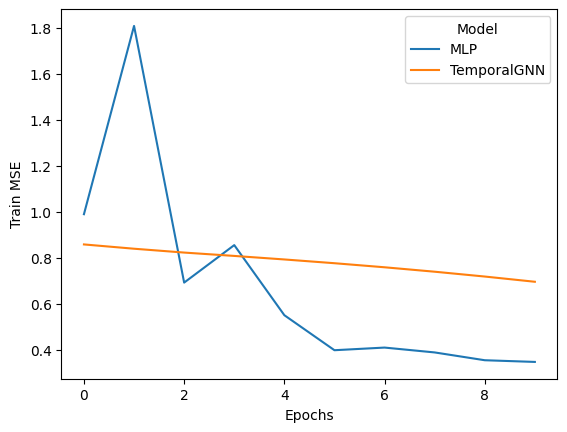

In [23]:
sns.lineplot(x='Epochs', y='Train MSE', hue='Model', data=df)

In [25]:
print(f'Test MSE MLP: {test_mse_mlp:.4f}')
print(f'Test MSE TemporalGNN: {test_mse_temporalgnn:.4f}')

Test MSE MLP: 29.0479
Test MSE TemporalGNN: 89.8145
